In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mido  # importe la bibliothèque MidO qui gère aussi RtMidi
import time  # importe le module Time Python
import pretty_midi
from tqdm.auto import tqdm
pd.set_option('display.max_rows',150)
import _pickle as pickle
import os
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

import random
import gc

from tf_transformers2 import *
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def play(mid):
    try:
        port = mido.open_output('Microsoft GS Wavetable Synth 0')

        # chemin absolu vers le fichier .mid, ici "blackvelvet.mid"


        # affiche chemin fichier Midi + son type + nb de pistes + nb de messages dans fichier
        print("=>", mid, "...\n... ...")

        # calcul + affiche la durée de lecture du fichier Midi en h:m:s
        print("=> Durée de lecture =", time.strftime('%Hh:%Mm:%Ss', time.gmtime(mid.length)))
        print("=> Lecture en cours...")

        for msg in mid.play():  
            port.send(msg)

        port.close()  # ferme proprement le port Midi
        print("=> Fichier MIDI lu... ARRÊT !")
    except:
        print('interrupted')
        port.close()
        
def play_from_pretty(mid):
    mid.write('temp.mid')
    mid1 = mido.MidiFile('temp.mid')
    play(mid1)

In [ ]:
play(mid.tracks[0])

In [ ]:
def get_max_time(mid):
    M = 0
    for inst in mid.instruments:
        for notes in inst.notes:
            if notes.end >= M:
                M = notes.end
    return M

def get_indice(time, tempo):
    return time*tempo/60*12

def inst_to_seq(instrument, length, tempo):
    velocity = np.zeros(length)
    pitch = np.zeros(length)
    
    inst = instrument.program
    is_drum = instrument.is_drum
    
    for note in instrument.notes:
        start = note.start
        end = note.end
        vel= note.velocity
        pi = note.pitch
        
        st = int(round(get_indice(start, tempo),0))
        en = int(round(get_indice(end, tempo),0))
        
        velocity[st:en] = vel
        pitch[st:en] = pi
    return inst, is_drum, velocity, pitch

def mid_to_seq(mid):
    
    tempo = mid.estimate_tempo()
    estimated_length = int(mid.estimate_tempo() * get_max_time(mid) * 12 / 60)
    
    seq = []    
    for instrument in mid.instruments:
#         print(instrument)
        inst, is_drum, velocity, pitch = inst_to_seq(instrument, estimated_length, tempo)
        
        seq.append({'instrument': inst,'is_drum' : is_drum,'tempo':tempo, 'velocity': velocity, 'pitch' : pitch, 'name':instrument.name})
    return seq

def seq_to_mid(seq):
    mid = pretty_midi.PrettyMIDI()
    
    for instrument in seq:
        inst = pretty_midi.Instrument(program=instrument['instrument'], is_drum = instrument['is_drum'], name = instrument['name'])
        tempo = instrument['tempo']
        velocity = instrument['velocity']
        pitch = instrument['pitch']
        st = 0
        
        v = velocity[0]
        p = pitch[0]
        
        for i, elt in enumerate(velocity):
            if velocity[i] != v or pitch[i] != p:
                en = (i-1)*60/12/tempo
                if v !=0 and p != 0:
                    note = pretty_midi.Note(velocity=int(v), pitch=int(p), start=st, end=en)
                    inst.notes.append(note)
                v = velocity[i]
                p = pitch[i]
                st = (i-1)*60/12/tempo
        mid.instruments.append(inst)
    return mid

## Data Prep

In [ ]:
mid = pretty_midi.PrettyMIDI('./data/0/009count.mid')

In [ ]:
play_from_pretty(mid)

In [ ]:
mid.instruments

In [ ]:
seq = mid_to_seq(mid)

In [ ]:
mid1 = seq_to_mid(seq)

In [ ]:
mid1.instruments

In [ ]:
play_from_pretty(mid1)

In [ ]:
seq[0]['velocity'].shape

In [ ]:
mid1.write('cello-C-chord.mid')

In [ ]:
dir(mid1)

In [ ]:
mid1.instruments

In [ ]:
help(tqdm)

In [ ]:
path_file = []
for path, subdirs, files in os.walk('./data'):
    for name in files:
        path_file.append(os.path.join(path, name))
#         print(os.path.join(path, name))

In [ ]:
path_file

In [ ]:
path_file_clean  =[]
for elt in path_file:
    if elt[-3:].lower() == 'mid':
        path_file_clean.append(elt.replace('\\', '/'))

In [ ]:
len(path_file_clean)

In [ ]:
path_file_clean

In [ ]:
batch = []
not_added  =[]
count= 0
count_not_added = 0
for elt in tqdm(path_file_clean):
    try:
        mid = pretty_midi.PrettyMIDI(elt)
        seq = mid_to_seq(mid)
        batch.append(seq)
        if len(batch) == 5000:
            save(batch, './batch/batch_'+str(count))
            count+=1
            batch = []
    except:
        not_added.append(elt)
        print(elt)
        print(count_not_added)
        count_not_added+=1
        
save(batch, './batch/batch_'+str(count))      

## Batch_loading

In [ ]:
batch = load('batch_0', 'batch')

In [ ]:
batch[0][0]

In [ ]:
batch[0]

In [2]:
class Tokenizer:
    def __init__(self, max_len):
        self.note_to_tok,  self.tok_to_note = self.build_dico()
        self.max_len = max_len
        
    def build_dico(self):
        dico = {}
        ## special tokens
        dico['[CLS]'] = 140
        dico['[SEP]'] = 141
        dico['[RES]'] = 142
        dico['[END]'] = 143
        dico['drum0'] = 144
        dico['drum1'] = 145
        dico['[PAD]'] = 146
        
        for i in range(0, 130):
            dico[str(i)] = i

        count = 150
        for i in range(130):
            for j in range(130):
                dico[str(i)+'_'+str(j)] = count
                count += 1
        
        dico1 = {}
        
        for elt in dico:
            dico1[dico[elt]] = elt
        return dico, dico1
    
    def encode(self,velocity, pitch ,instrument, drum = 'drum0', start = True, pad = True):
        seq = []
        
        if start:
            seq.append(self.note_to_tok['[CLS]'])
        else:
            seq.append(self.note_to_tok['[RES]'])
        
        seq.append(self.note_to_tok[str(instrument)])
        seq.append(self.note_to_tok['[SEP]'])
        seq.append(self.note_to_tok[str(drum)])
        seq.append(self.note_to_tok['[SEP]'])
        
        for i, elt in enumerate(range(max(len(velocity), len(pitch)))):
            seq.append(self.note_to_tok[str(int(velocity[i]))+'_'+str(int(pitch[i]))])
    
        if len(seq) >= self.max_len:
            seq = seq[:self.max_len]
        
        if len(seq) < self.max_len:
            seq.append(self.note_to_tok['[END]'])
            while len(seq) < self.max_len:
                seq.append(self.note_to_tok['[PAD]'])
        
        return seq
    
    def decode(self, seq):
        instrument = self.tok_to_note[seq[1]]
        drum = self.tok_to_note[seq[3]]
        if drum == 'drum0':
            drum  = False
        else:
            drum = True
        
        velocity = []
        pitch = []
        
        for elt in seq[5:]:
            if elt != 146 and elt != 143:
                dec = self.tok_to_note[elt]
                dec = dec.split('_')
                velocity.append(int(dec[0]))
                pitch.append(int(dec[1]))
        return {
            'instrument' : instrument,
            'is_drum' : drum,
            'velocity' : velocity,
            'pitch' : pitch
        }
    


In [3]:
def encode_channel(channel, start = True, max_len = 1024):
    pitch = channel['pitch']
    instrument = str(channel['instrument'])
    drum = channel['is_drum']
    velocity = channel['velocity']
    pitch = channel['pitch']   
    
    if drum:
        drum = 'drum0'
    else:
        drum = 'drum1'
    if start == True:
        seq = tokenizer.encode(velocity[:max_len], pitch[:max_len] ,instrument, drum = drum, start = True, pad = True)
    else:
        seq = tokenizer.encode(velocity[start:max_len+start], pitch[start:max_len+start] ,instrument, drum = drum, start = False, pad = True)
    return seq

In [4]:
def encode_mid(mid, start = True, max_len = 1024, max_channel = 10):
    
    encoded = np.zeros((max_channel, max_len))
    
    for i, channel in enumerate(mid):
        if i < 10:
            seq = encode_channel(channel, start = start, max_len = max_len)
            encoded[i,:] = seq
    mask = 1-(np.array(seq)==146)*1
    
    return encoded.astype(int), mask.astype(int)
                    
                       

In [5]:
tokenizer = Tokenizer(max_len = 1024)

In [6]:
from tensorflow.keras.utils import Sequence

class Generator(Sequence):
    def __init__(self, batch_size = 32, start_rate = 0.2, change_rate = 0.01, max_len = 1024, max_channel = 10):
        self.change_rate = change_rate
        self.start_rate = start_rate
        self.file = self.get_batch()
        self.batch_size = batch_size
        self.max_len = max_len
        self.max_channel = max_channel
        self.tokenizer = Tokenizer(max_len = max_len)
        
        
        
    def get_batch(self):
        file  = random.choice(os.listdir('./batch'))
        working_file = load(file.split('.')[0], 'batch')
        return working_file
    
    def __len__(self):
        return int(10000000)
    
    def __getitem__(self, idx):
        ## Changing file
        r = random.uniform(0,1)
        if r < self.change_rate:
            self.close()
            self.file = get_batch()
        
        batch = np.random.choice(self.file, size = self.batch_size)
        
        X = []
        masks = []
        tempo = []
        for elt in batch:
            seq_len = len(elt[0]['velocity'])
            t = [int(elt[0]['tempo']) for _ in range(self.max_len)]
            tempo.append(t)
            
            r = random.uniform(0,1)
            
            if r <= self.start_rate:
                enc, mask = encode_mid(elt, start = True, max_len = self.max_len, max_channel = self.max_channel)
            
            else:
                n = random.randint(50, seq_len)
                enc, mask = encode_mid(elt, start = n, max_len = self.max_len, max_channel = self.max_channel)
        
            
            X.append(enc)
            masks.append(mask)
            
        X = np.array(X)
        masks = np.array(masks)
        tempo = np.array(tempo).astype('int')
        
        y = []
        for j in range(len(X)):
            i = random.randint(0, self.max_channel-1)
            y.append(X[j][i,:])
            X[j][i,0] = 147
        
        y = np.array(y)
        
        return [X[:,:,:-1], masks[:,:-1], tempo[:,:-1]], y[:,1:]
    
    def close(self):
        del self.file
        gc.collect()

In [ ]:
gen = Generator(batch_size = 16, start_rate = 0.2, change_rate = 0.0, max_len = 1024, max_channel = 10)

In [ ]:
%%time
X, y = gen[1]

In [ ]:
gen.close()

In [ ]:
X[0][1]

In [ ]:
y[1]

In [7]:
class GPTDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, num_types = 2, rate=0.1, bidirectional_decoder = False, max_channel = 10):
        super(GPTDecoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(17050, int(d_model/max_channel))
        self.tempo_encoding = tf.keras.layers.Embedding(1000, d_model)
        
        self.conc = tf.keras.layers.Concatenate(axis = -1)
        
        self.agg = tf.keras.layers.Dense(d_model, activation = 'relu')
        
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [GPTDecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        self.max_channel = max_channel
        self.bidirectional_decoder = bidirectional_decoder
    
    def call(self, x, 
             masks = None,
             tempo = None,
             training = True):

        seq_len = tf.shape(x[:,0,:])[1]
        
        attention_weights = {}
        
        if self.bidirectional_decoder == False:
            look_ahead_mask = create_look_ahead_mask(tf.shape(x[:,0,:])[1])
            dec_target_padding_mask = create_padding_mask(masks)
            mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
#             mask = look_ahead_mask
#             print(mask)
            
        else:
            mask = create_padding_mask(masks) 
        x = [self.embedding(x[:,i,:]) for i in range(self.max_channel)]  # (batch_size, target_seq_len, d_model)
        x = self.conc(x)
        x = self.agg(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        tempo_emb = self.tempo_encoding(tempo)
        x += tempo_emb
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1 = self.dec_layers[i](x, training, look_ahead_mask = mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
        return x  

In [8]:

decoder = GPTDecoder(num_layers = 2, d_model = 400, num_heads = 8, dff = 512, target_vocab_size = 1,
                   maximum_position_encoding = 1024, num_types = 2, rate=0.1, bidirectional_decoder = False, max_channel = 10)

In [ ]:
del decoder
del model
gc.collect()
tf.keras.backend.clear_session()

In [9]:
inputs_ids = Input(shape = ( 10,1023))
inputs_masks = Input(shape = ( 1023,))
inputs_tempo = Input(shape = ( 1023,))

inputs = [inputs_ids, inputs_masks, inputs_tempo]

encoded = decoder(
    inputs_ids,
    masks = inputs_masks,
    tempo=inputs_tempo, 
        )

# dense_layers = [tf.keras.layers.Dense(17050, activation = 'softmax')(encoded) for _ in range(10)]
outputs = tf.keras.layers.Dense(17050)(encoded)


model = Model(inputs, outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=True, reduction='none')

loss_classif     =  loss_object# find the right loss for multi-class classification
optimizer        =  Adam(3e-5, 1e-8) # find the right optimizer
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

In [10]:
## Test_set
gen = Generator(batch_size = 64, start_rate = 0.2, change_rate = 0.0, max_len = 1024, max_channel = 10)
x_test, y_test = gen[0]
gen.close()

In [ ]:
## Train_set
gen = Generator(batch_size = 2048, start_rate = 0.2, change_rate = 0.0, max_len = 1024, max_channel = 10)
x_train, y_train = gen[0]
gen.close()

In [ ]:
gen = Generator(batch_size = 4096, start_rate = 0.2, change_rate = 0.1, max_len = 1024, max_channel = 10)


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, 
                                                mode='auto', restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, 
                                                     mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

bs = 128
n_epochs = 10
step_per_epoch = 100
#, batch_size=bs

for i in range(20):
    x_train, y_train = gen[0]
    history = model.fit(x_train, y_train,  epochs=1, batch_size = 16, validation_data=(x_test,  y_test))#, callbacks = [early, reduce])
    
gen.close()

In [ ]:
gen.close()

In [ ]:
help(model.predict)

In [ ]:
model.save_weights('./checkpoints/weights_1.h5')

In [11]:
model.load_weights('./checkpoints/weights.h5')

In [12]:
a = model.predict(x_test, batch_size = 16,verbose = 1)

64/64 [==============================] - 7s 104ms/sample


In [14]:
a.shape

(64, 1023, 17050)

In [15]:
b = np.argmax(a, axis = -1)

In [16]:
b

array([[141, 141, 145, ..., 150, 150, 150],
       [141, 141, 145, ..., 150, 150, 150],
       [141, 141, 145, ..., 150, 150, 150],
       ...,
       [141, 141, 145, ..., 146, 146, 146],
       [  0,   0,   0, ...,   0,   0,   0],
       [141, 141, 145, ..., 146, 146, 146]], dtype=int64)

In [32]:
y_test[11][:20]

array([   87,   141,   145,   141, 13223, 13223, 13223, 13223,   150,
         150, 13218, 13218, 13218, 13218,   150,   150, 13220, 13220,
       13220, 13220])

(array([1.015e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 5.000e+00]),
 array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,
         33.,  36.,  39.,  42.,  45.,  48.,  51.,  54.,  57.,  60.,  63.,
         66.,  69.,  72.,  75.,  78.,  81.,  84.,  87.,  90.,  93.,  96.,
         99., 102., 105., 108., 111., 114., 117., 120., 123., 126., 129.,
        132., 135., 138., 141., 144., 147., 150.]),
 <BarContainer object of 50 

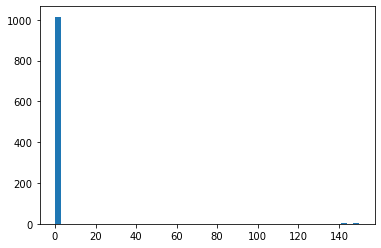

In [59]:
plt.hist(b[19], bins = 50)